In [1]:
//#pragma include_alias("/local/vtk-m/clang/include/vtkm-1.2/vtkm/thirdparty/taotuple/vtkmtaotuple/","vtkmtaotuple")
#pragma cling add_include_path("/home/ybk/local/vtk-m-1.3.0/include/vtkm-1.3/")
#pragma cling add_include_path("/home/ybk/Projects/vtkm-uflic/")
#pragma cling add_library_path("/home/ybk/local/vtk-m-1.3.0/lib/")
#pragma cling load("vtkm_cont-1.3")
#pragma cling load("vtkm_rendering-1.3")


#pragma cling add_library_path("/home/ybk/local/anaconda3/envs/cling/lib/")
#pragma cling load("lodepng")


In [2]:
#include <vtkm/cont/DeviceAdapter.h>
#include <vtkm/cont/testing/MakeTestDataSet.h>
#include <vtkm/cont/testing/Testing.h>
#include <vtkm/rendering/Actor.h>
#include <vtkm/rendering/Mapper.h>
#include <vtkm/rendering/Scene.h>
#include <vtkm/rendering/View3D.h>
#include <vtkm/cont/ColorTable.h>
#include <vtkm/rendering/testing/RenderTest.h>
#include <vtkm/io/reader/VTKDataSetReader.h>
#include <vtkm/cont/internal/IteratorFromArrayPortal.h>
#include <vtkm/cont/ArrayPortalToIterators.h>
#include <vtkm/cont/DynamicArrayHandle.h>
#include <vtkm/cont/ArrayCopy.h>
#include <vtkm/worklet/Normalize.h>
#include <vtkm/worklet/DispatcherMapField.h>
#include "Reader.h"
#include "UFLIC.h"
#include "ViewUFLIC.h"
#include "CanvasUFLIC.h"
#include "MapperUFLIC.h"
#include "ReaderUFLIC.h"
#include "ScreenSpaceLIC.h"




Use lodepng to save out png instead of pnm so jupyter can read it.


In [3]:
#include <VTKmXeusRender.h>


The default vtkm::rendering::View3D render both world space annotations (think bounding measuring box) and screen space annotations (think color bar). For screen space line integral convolution, we need to remove those.

In [4]:
inline vtkm::cont::DataSet readVTKDataSet(const char* fname)
{
  vtkm::cont::DataSet ds;
  vtkm::io::reader::VTKDataSetReader reader(fname);
  try
  {
    ds = reader.ReadDataSet();
  }
  catch (vtkm::io::ErrorIO& e)
  {
    std::string message("Error reading: ");
    message += fname;
    message += ", ";
    message += e.GetMessage();

    VTKM_TEST_FAIL(message.c_str());
  }

  return ds;
}

In [5]:
void addField(vtkm::cont::DataSet &ds){
    auto cnt = ds.GetField(0).GetData().GetNumberOfValues();
    vtkm::cont::DataSetFieldAdd dsf;
    std::vector<vtkm::Float32> vars(cnt);
    for (int i=0; i<cnt ;i++){
        vars[i] = vtkm::Float32(i)/vtkm::Float32(cnt);
    }
        
    
    dsf.AddPointField(ds, "pointvar", vars);

}

In [6]:

vtkm::cont::ColorTable buildColorTableFromArray(const vtkm::cont::DynamicArrayHandle &_h){
    
    auto handle = _h.Cast<vtkm::cont::ArrayHandle<vtkm::Vec<vtkm::Float32,3>>>();
    vtkm::worklet::DispatcherMapField<vtkm::worklet::Normalize>(
        vtkm::worklet::Normalize())
        .Invoke(handle);

    std::vector<double> out(_h.GetNumberOfValues()*4);
    for (int i=0; i<handle.GetNumberOfValues(); i++){
        auto tmp = handle.GetPortalConstControl().Get(i);
        out[i*4] = tmp[0];
        out[i*4+1] = tmp[1];
        out[i*4+2] = tmp[2];
        out[i*4+3] = 0.0;
        if (i == 0)
            std::cout << handle.GetPortalConstControl().Get(i) << std::endl;
    }


    std::string name = "inplace";
    vtkm::Vec<double,3> nanIs(0,0,0);
     return vtkm::cont::ColorTable(name, vtkm::cont::ColorSpace::RGB, nanIs, 
                              out);
    
};

In [7]:
 
// vtkm::cont::ArrayHandle<int> runUFLIC(vtkm::rendering::Canvas &canvas)
// {
//     const int Size = 2;
//     using VecType = vtkm::Float32;
//     using ReaderType = ReaderUFLIC<VecType, Size>;

//     auto reader = std::shared_ptr<ReaderType>(new ReaderType(canvas));
//     UFLIC<VectorField<VecType,Size>,VecType,Size> uflic;
//     uflic.do_print = true;
//     uflic.run(reader);
//     return uflic.result;

// };



In [8]:
auto mapper = std::unique_ptr<MapperUFLIC>();
auto canvas = std::unique_ptr<CanvasUFLIC>();
auto scene = std::unique_ptr<vtkm::rendering::Scene>();
auto camera = std::unique_ptr<vtkm::rendering::Camera>();
auto view = std::unique_ptr<ViewUFLIC>();
auto lic = std::unique_ptr<ScreenSpaceLIC<VectorField< vtkm::Float32,2>, vtkm::Float32>>();
auto dim = std::unique_ptr<vtkm::Id2>();
VTKmXeusRender render;


In [9]:


[&](){
auto try_and_err = [&](){
dim = std::unique_ptr<vtkm::Id2>(new vtkm::Id2(512,512));
mapper = std::unique_ptr<MapperUFLIC>(new MapperUFLIC());
canvas = std::unique_ptr<CanvasUFLIC>(new CanvasUFLIC((*dim)[0],(*dim)[1]));
scene = std::unique_ptr<vtkm::rendering::Scene>(new vtkm::rendering::Scene());
camera = std::unique_ptr<vtkm::rendering::Camera>(new vtkm::rendering::Camera());
view = std::unique_ptr<ViewUFLIC>(new ViewUFLIC(*scene, *mapper, *canvas, *camera, vtkm::rendering::Color(0,0,0,1), vtkm::rendering::Color(1,0,0,1)));

mapper->SetShadingOn(false);
auto ds = readVTKDataSet("/home/ybk/render/data/ice-train-vel.vtk");
addField(ds);
auto colorTable = buildColorTableFromArray(ds.GetField("vectors").GetData());
static std::string fieldNm = "pointvar";
render.Render(ds, *mapper, *canvas, colorTable, fieldNm);

    };
    try_and_err();
}();


[0.985389,-0.00133301,0.170312]


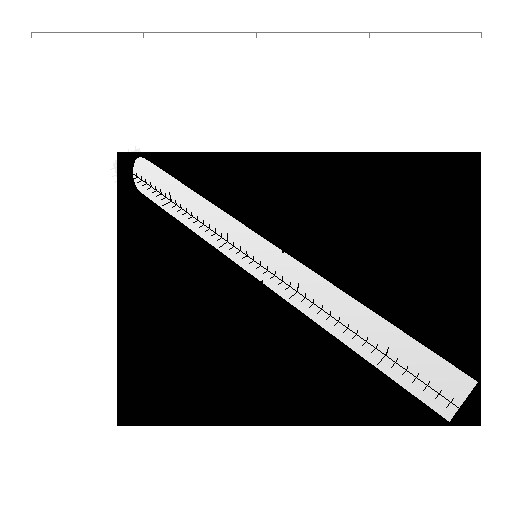

In [10]:
#include <xcpp/xdisplay.hpp>

[&](){
auto try_and_err = [&](){



    render.Display(*canvas);


    auto png = convertPng(*canvas);

    
    
};
try_and_err();
}()

In [11]:
[&]() 
{
auto try_and_err = [&]()
{
    lic = std::unique_ptr<ScreenSpaceLIC<VectorField< vtkm::Float32,2>, vtkm::Float32>>(new ScreenSpaceLIC<VectorField< vtkm::Float32,2>, vtkm::Float32>(*dim, 5.0, 4, 4));
    vtkm::cont::ArrayHandleCounting<vtkm::Id> indexArray(vtkm::Id(0), 1, (*dim)[0]*(*dim)[1]);

    lic->draw(canvas->pixelVel, indexArray, canvas->GetDepthBuffer());
};
try_and_err();
}();


5


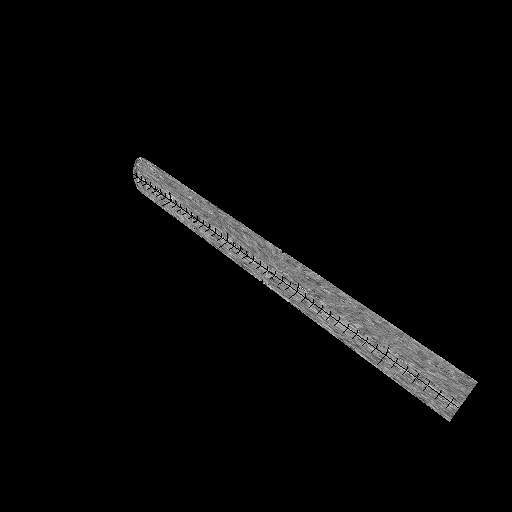

In [12]:
[&]() 
{
auto try_and_err = [&]()
{
    VTKmXeusRender render2;
    render2.Display(lic->result, canvas->GetWidth(), canvas->GetHeight()) ;
};
try_and_err();
}();